In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from random import randint
import timeit
from sympy import *
%matplotlib inline

Здесь собраны вспомогательные функции, в частности обратный ход метода Гаусса, решение системы линейных уравнений через $LU$-разложение, решение задачи наименьших квадратов через домножение на транспонированную матрицу, а также решение квадратного уравнения.

In [3]:
def solve_Ax_b(A, b, left_triangle_A=False):
    assert(A.shape[0] == A.shape[1] == b.shape[0])
    order = A.shape[0]
    solution = np.zeros(shape=(order, 1), dtype=complex)
    for i in range(order) if left_triangle_A else reversed(range(order)):
        current_sol = b[i] / A[i,i]
        for j in range(i + 1, order) if left_triangle_A else range(i):
            b[j] = b[j] - b[i] * A[j, i] / A[i, i]
        solution[i] = current_sol
    return solution


def Polynom_solve(c_1, c_0):
    return -c_1 / 2 + np.sqrt(abs(float(c_1 * c_1 - 4 * c_0))) / 2 * 1j, -c_1 / 2 - np.sqrt(abs(float(c_1 * c_1 - 4 * c_0))) / 2 * 1j


def LU(matrix):
    order = matrix.shape[0]
    for j in range(order):
        for i in range(order):
            matrix[i, j] = matrix[i, j] - sum(matrix[i, k] * matrix[k, j] for k in range(min(i, j)))
            if i > j:
                matrix[i, j] = matrix[i, j] / matrix[j, j]
    L = eye(order)
    U = zeros(order)
    for i in range(order):
        for j in range(order):
            if i > j:
                L[i, j] = matrix[i, j]
            else:
                U[i, j] = matrix[i, j]
    return L, U


def LU_solve_whole_system(matrix):
    L, U = LU(matrix.copy())
    return solve_Ax_b(U, solve_Ax_b(L, matrix[:, matrix.shape[1] - 1].copy(), True))


def Least_squares_solve(A, b):
    LHS = A.transpose() * A
    RHS = A.transpose() * b
    LHS = np.insert(LHS, 2, RHS.transpose(), axis=1)
    return LU_solve_whole_system(LHS)


def generate_quadratic_matrix(order):
    assert(order >= 1)
    matrix = np.matrix([[0] * (order + 1)] * order, dtype=float)
    for i in range(order):
        for j in range(order + 1):
            matrix[i, j] = randint(1, 50)
    return matrix

Алгоритмы для нескольких вариантов возможных максимальных по модулю собственных значений отдельно. 

In [346]:
def real_case_one(A, u, A_u):
    '''
    Finds a solution in case, where eigen value l_1 has maximal norm, i.e. |l_1| >= |l_2| ... . 
    '''
    l = np.dot(u.transpose(), A_u)[0, 0]
    if np.linalg.norm(A_u - l * u) > 10 ** (-9):
        return False
    else:
        return l, u

    
def real_case_two(A, u, A_u, AA_u):
    '''
    Finds a solution in case, where eigen value l_1 has maximal norm, i.e. |l_1| >= |l_2| ..., and l_1 = -l_2.
    '''
    ip = np.dot(u.transpose(), AA_u)[0, 0]
    if ip < 0:
        return False
    l = np.sqrt(ip)
    eigen_1 = A_u * l + AA_u
    eigen_1 = eigen_1 / np.linalg.norm(eigen_1)
    if np.linalg.norm(np.dot(A, eigen_1) - l * eigen_1) > 10 ** (-9):
        return False
    else:
        eigen_2 = A_u * l - AA_u
        eigen_2 = eigen_2 / np.linalg.norm(eigen_2)
        if np.linalg.norm(np.dot(A, eigen_2) + l * eigen_2) > 10 ** (-9):
            return False
        return l, eigen_1, -l, eigen_2

    
def complex_case(A, u, A_u, AA_u):
    '''
    Finds a solution in case, where complex eigen value l_1 has maximal norm, i.e. |l_1| = |l_2| > ... . 
    '''
    vec = Least_squares_solve(np.concatenate((u, A_u), axis=1), -AA_u)
    a = vec[0, 0]
    b = vec[1, 0]
    l1, l2 = Polynom_solve(b, a)
    eigen_1 = A_u - u * l2
    eigen_1 = eigen_1 / np.linalg.norm(eigen_1)
    if np.linalg.norm(np.dot(A, eigen_1) - l1 * eigen_1) > 10 ** (-9):
        return False
    eigen_2 = A_u - u * l1
    eigen_2 = eigen_2 / np.linalg.norm(eigen_2)
    if np.linalg.norm(np.dot(A, eigen_2) - l2 * eigen_2) > 10 ** (-9):
        return False
    return l1, eigen_1, l2, eigen_2


def Eigen_value_detecter(A, number_of_iterations, init_printing):
    size = A.shape[0]
    u = np.random.rand(size,1)
    u = u / np.linalg.norm(u)
    for i in range(number_of_iterations):
        u = np.dot(A, u)
        u = u / np.linalg.norm(u)
        au = np.dot(A, u)
        if (real_case_one(A, u, au) != False):
            if init_printing:
                print('Eigen value:\n', real_case_one(A, u, au)[0])
                print('Eigen vector:\n', real_case_one(A, u, au)[1])
            return
        AA_u = np.dot(A, au)
        if (real_case_two(A, u, au, AA_u) != False):
            if init_printing:
                print('Eigen values:\n', real_case_two(A, u, au, AA_u)[0], '\n', real_case_two(A, u, au, AA_u)[2])
                print('Eigen vectors:\n', real_case_two(A, u, au, AA_u)[1], '\n', real_case_two(A, u, au, AA_u)[3])
            return
        if (complex_case(A, u, au, AA_u) != False):
            if init_printing:
                print('Eigen values:\n', complex_case(A, u, au, AA_u)[0], '\n', complex_case(A, u, au, AA_u)[2])
                print('Eigen vectors:\n', complex_case(A, u, au, AA_u)[1], '\n', complex_case(A, u, au, AA_u)[3])
            return
    print(f'Алгоритм не сошелся за {number_of_iterations} итераций.')
        
        
Eigen_value_detecter(A, 1000, True)

Eigen values:
 (-0.916367575861046+3.925408635266307j) 
 (-0.916367575861046-3.925408635266307j)
Eigen vectors:
 [[ 0.35965647-0.18110326j]
 [ 0.1347151 +0.02009192j]
 [-0.15247476+0.25578657j]
 [ 0.24192759+0.36018973j]
 [-0.19568154-0.07867445j]
 [ 0.00260182+0.49449287j]
 [-0.21451862-0.17056793j]
 [ 0.11614702+0.18011606j]
 [-0.23468133+0.12610043j]
 [ 0.2080197 -0.13436049j]] 
 [[ 0.35965647+0.18110326j]
 [ 0.1347151 -0.02009192j]
 [-0.15247476-0.25578657j]
 [ 0.24192759-0.36018973j]
 [-0.19568154+0.07867445j]
 [ 0.00260182-0.49449287j]
 [-0.21451862+0.17056793j]
 [ 0.11614702-0.18011606j]
 [-0.23468133-0.12610043j]
 [ 0.2080197 +0.13436049j]]


In [5]:
A = np.matrix([[1, -2, 1, 0, -1, 1, -2, 2, 0, -2],
               [0, 2, 0, 0, 2, 1, -1, -1, -1, -2],
               [0, 1, 0, -1, 1, -1, 0, -1, 1, -1],
               [-2, -1, 2, -1, 0, 0, 0, 0, 1, 0],
               [1, -2, 0, 1, 0, -2, -1, 0, 2, 2],
               [-2, -2, 0, -2, 0, 1, 1, -2, 1, 1],
               [-1, -2, -1, -1, -2, -1, -2, 1, -1, 2],
               [-2, 1, 2, -2, 0, 2, 1, -1, -2, 2],
               [0, 1, 0, 1, 1, -2, 2, 0, 1, 1],
               [0, 0, 2, -1, -1, 0, -2, 2, -1, -1]], dtype=float)

<ipython-input-346-f34d58407ca4>:41: RuntimeWarning: invalid value encountered in true_divide
  eigen_1 = eigen_1 / np.linalg.norm(eigen_1)
<ipython-input-346-f34d58407ca4>:45: RuntimeWarning: invalid value encountered in true_divide
  eigen_2 = eigen_2 / np.linalg.norm(eigen_2)


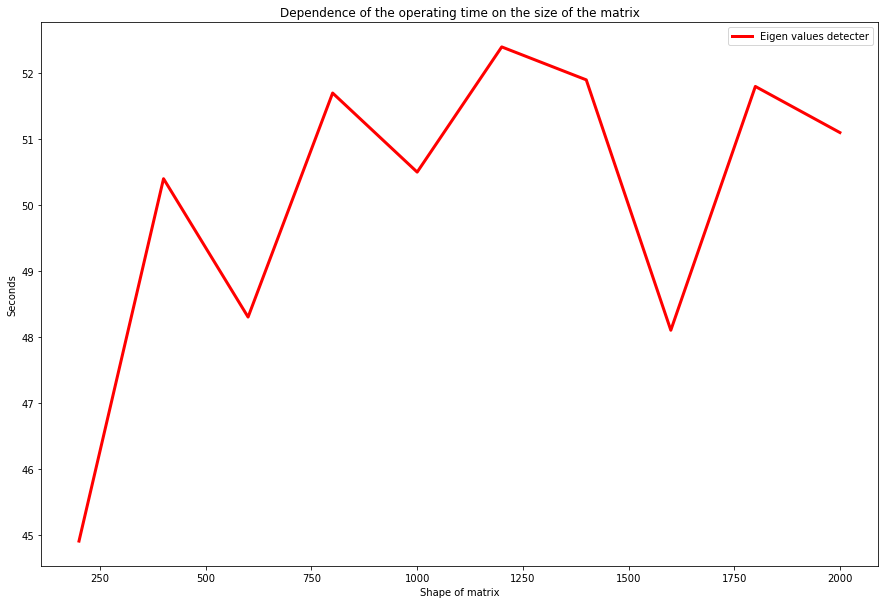

In [369]:
list_of_orders = [200 * i for i in range(1, 11)]
list_of_time_task_1 = []

def solving_time(order):
    matrix = generate_quadratic_matrix(order)
    result = %timeit -n1 -r1 -o -q -p0 Eigen_value_detecter(matrix[:order, :order], 1000, False)
    list_of_time_task_1.append(result.compile_time)
    
    
for o in list_of_orders:
    solving_time(o)
plt.figure(figsize=[15, 10])
plt.plot(list_of_orders, [t * (10 ** 6) for t in list_of_time_task_1], color='red', linewidth=3, label='Eigen values detecter')
plt.ylabel('Seconds')
plt.xlabel('Shape of matrix')
plt.title('Dependence of the operating time on the size of the matrix')
plt.legend()
plt.show()

In [ ]:
B = np.matrix([[-1, 1, -1, 0, -1, 0, -1, 1, 1, -1, 0, -1, -1, 1, 0, 0, 1, 1, 1, 1],
               [-1, 0, -1, 1, -1, 0, 0, 0, 0, -1, 0, 0, -1, 1, 0, -1, 1, -1, -1, 0],
               [1, 0, -1, 1, 0, 1, -1, -1, -1, 0, -1, -1, 1, -1, 1, 1, -1, 1, -1, 0],
               [-1, 1, 0, 0, -1, 0, 0, -1, 0, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 0],
               [1, 0, -1, 0, 0, -1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, -1, 0, 0, 1],
               [0, 0, 0, 0, -1, 1, 1, 0, 0, 1, 1, 0, -1, 0, 1, 1, 0, 1, 0, 0],
               [-1, 0, 1, 1, 1, -1, -1, 0, -1, 1, -1, -1, -1, 0, -1, 0, 0, 0, -1, 1],
               [0, 0, -1, -1, 0, 1, 1, 1, 1, -1, 0, 0, -1, 1, 1, 1, 1, 0, 0, -1], 
               [0, 0, 1, 1, 0, 1, 1, 0, 1, -1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
               [0, -1, 0, 0, 1, 0, -1, 0, -1, 0, -1, 0, -1, 0, 1, -1, 0, 0, 1, 1],
               [1, -1, 1, -1, -1, -1, 1, 0, -1, 0, 1, 1, -1, 0, 1, 1, 1, 0, 0, 0],
               [0, 1, 0, 0, -1, 0, 1, 0, 1, 0, 0, 1, 1, -1, -1, 0, -1, 1, 1, -1],
               [-1, -1, -1, -1, 0, 1, -1, 0, 0, -1, 0, 0, 0, 1, 1, 0, 0, 0, -1, 0],
               [-1, 0, 1, 0, -1, 0, 0, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 0],
               [1, -1, 0, -1, -1, 0, -1, -1, 0, 0, 1, 0, 1, 1, -1, 1, 0, 0, -1, 0],
               [-1, -1, 1, 0, -1, 1, 1, -1, 1, 0, 0, -1, 1, -1, -1, 0, 0, 1, 1, 1],
               [0, 0, -1, 0, 0, 0, 0, -1, 1, 1, 0, -1, 1, -1, 0, 0, 0, -1, -1, 1],
               [-1, 0, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 0, -1, 0, -1],
               [-1, 0, 1, 0, 0, 0, 0, -1, 1, -1, 1, -1, 0, -1, -1, 1, 0, 1, 0, 0],
               [0, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 0, -1, -1, 0, 1, 0, -1, -1]], dtype=float)

Метод Данилевского.

In [253]:
def Danilevsky_method(A):
    '''
    Danilevsky method for all matrices. It produces cases where main element is zero, or any 
    element in current row are zeros. Returns a modified matrix in Frobenius form.
    '''
    n = A.shape[0]
    for i in reversed(range(1, n)):
        if abs(A[i, i - 1]) < 10 ** (-6):
            for k in reversed(range(0, i - 2)):
                if A[i, k] != 0:
                    A[:, i - 1], A[:, k] = A[:, k], A[:, i - 1]
                    A[i - 1, :], A[k, :] = A[i - 1, :], A[k, :]
            if abs(A[i, i - 1]) < 10 ** (-6):
                continue
        c = A[i, i - 1]
        A[:, i - 1] = A[:, i - 1] / c
        A[i - 1, :] = A[i - 1, :] * c
        for j in reversed(range(n)):
            if j != i - 1:
                c = copy.copy(A[i, j])
                A[:, j] = A[:, j] - c * A[:, i - 1]
                A[i - 1, :] = A[i - 1, :] + c * A[j, :]
    for i in range(n):
        for j in range(n):
            if A[i, j] < 10 ** (-6):
                A[i, j] = 0
    return A


Danilevsky_method(B)

Характеристический многочлен матрицы $B$:

In [252]:
lamda = symbols('lamda')
car_polynom = lamda ** B.shape[0] + sum(-lamda ** i * B[0, i] for i in range(B.shape[1]))
car_polynom

lamda**20 - 1.0*lamda**19 - 1.0*lamda**18 - 1.0*lamda**17 - 1.0*lamda**16 - 1.0*lamda**13 + 1.0*lamda**12 + 1.0*lamda**11 + 1.0*lamda**9 - 1.0*lamda**8 - 1.0*lamda**7 + 1.0*lamda**6 + 1.0*lamda**4 + 1.0*lamda**2 - 1.0*lamda + 1.0

Корень $\lambda_0 = 1$ угадывается легко. Получим следующий полином: $Q(\lambda) = P(\lambda) / (\lambda - 1)$.
$$
    Q(\lambda) = \lambda^{19} - \lambda^{17} - 2\lambda^{16} - 3\lambda^{15} -3\lambda^{14} - 3\lambda^{13} - 4\lambda^{12} - 3\lambda^{11} - 2\lambda^{10} - 2\lambda^9 - \lambda^8 - 2\lambda^7 - 3\lambda^6 - 2\lambda^5 -2\lambda^4 - \lambda^3 - \lambda^2 - 1.
$$
Найдем вещественный корень многочлена $Q(\lambda)$. Покажем, что данный корень $\lambda_1$ принадлежит отрезку $[1.5, 3].$ Во-первых, $Q(1.5) < 0, Q(3) > 0, Q'(\lambda) > 0$ на отрезке $[1.5, 3]$.


In [267]:
def Q(x):
    return x ** 19 - x ** 17 - 2 * x ** 16 - 3 * x ** 15 -3 * x ** 14 - 3 * x ** 13 - 4 * x ** 12 - 3 * x ** 11 - 2 * x ** 10 - 2 * x ** 9 - x ** 8 - 2 * x ** 7 - 3 * x ** 6 - 2 * x ** 5 -2 * x ** 4 - x ** 3 - x ** 2 - 1

def Q_derrivative(x):
    return 19 * x ** 18 - 17 * x ** 16 - 2 * 16 * x ** 15 - 3 * 15 * x ** 14 - 3 * 13 * x ** 12 - 4 * 12 * x ** 11 - 33 * x ** 10 - 20 * x ** 9 - 18 * x ** 8 - 8 * x ** 7 - 18 * x ** 5 - 10 * x ** 4 - 8 * x ** 3 - 3 * x * x - 2 * x

def Q_second_derrivative(x):
    return 19 * 18 * x ** 17 - 17 * 16 * x ** 15 - 30 * 16 * x ** 14 - 45 * 14 * x ** 13 - 36 * 13 * x ** 11 - 44 * 12 * x ** 10 - 330 * x ** 9 - 180 * x ** 8 - 18 * 8 * x ** 7 - 8 * 7 * x ** 6 - 18 * 5 * x ** 4 - 40 * x ** 3 - 24 * x * x - 6 * x - 2 


def bisection(a, b, fun):
    while abs(b - a) > 0.02:
        x = (a + b) / 2
        if sign(fun(x)) != sign(fun(a)):
            b = x
        else:
            a = x
    return (a, b)


def simple_iteration(a, b, x, func, derrivative):
    x_previous = a
    l = 1 / derrivative(x_previous)
    while abs(x - x_previous) / np.sqrt(x * x + x_previous * x_previous) > 0.000000001:
        x = x - func(x) * l
        x_previous = x
    return x

In [259]:
bisection(1.5, 3, Q)

(1.921875, 1.93359375)

In [265]:
simple_iteration(1.921875, 1.93359375, 1.922, Q, Q_derrivative)

1.927541138617727

Теперь покажем, что $Q(\lambda)$ больше не имеет действительных корней. Во-первых, для $x > 3$ $Q'(x) > 0$, и функция $Q(x)$ положительна и строго возрастает.

Во-вторых, $Q(x) < 0$ для $x\in (-\infty, 1)$. Действительно, рассмотрим на данном промежутке производную $Q'(x)$ и найдем ее корень методом простой итерации. 

In [275]:
bisection(-10, 1, Q_derrivative)

(-0.009765625, 0.0009765625)

In [278]:
derrivative_root = simple_iteration(-0.009765625, 0.0009765625, 0.00093, Q_derrivative, Q_second_derrivative)
derrivative_root

-2.829643627744985e-05

Таким образом, до найденного корня $x_0$ функция $Q$ монотонно возрастает ($Q'(x) > 0$), а на отрезке после и до единицы монотонно убывает. Так как $Q(x_0) < 0$, то и $Q(x) < 0$ на промежутке $(-\infty, 1).$ 

Очевидно, что на отрезке $(1, \lambda_1)$ функция отрицательна. Следовательно, у $Q(x)$ больше нет действительных корней.

In [279]:
Q(derrivative_root)

-1.0000000008006658

Нахождение собственных векторов для собственных значений $\lambda_0 = 1$ и $\lambda_1 = 1.927541138617727.$

Приведение матрицы к форме Хессенберга и реализация $QR$-алгоритма.

In [6]:
def Arnoldi_algorithm(matrix, num_of_iterations=1, one_step=True):
    H = zeros(matrix.shape[0] + 1, matrix.shape[0])
    Q = zeros(matrix.shape[0], matrix.shape[0] + 1)
    b = zeros(matrix.shape[0], 1)
    b[0, 0] = 1
    Q[:, 0] = b 
    for j in range(num_of_iterations) if not one_step else range(num_of_iterations, num_of_iterations + 1):
        z = matrix * Q[:, j]
        for i in range(j + 1):
            H[i, j] = z.transpose() * Q[:, i]
            H[i, j] = round(H[i, j], 2)
            z = z - H[i, j] * Q[:, i]
        H[j + 1, j] = np.sqrt(float(sum([x * x for x in z])))
        if abs(H[j + 1, j]) <= 10 ** (-9):
            return Q[:, :matrix.shape[0]], H[:matrix.shape[0], :]
        Q[:, j + 1] = z / H[j + 1, j]
    if not one_step:
        return Q[:, :matrix.shape[0]], H[:matrix.shape[0], :]
    else:
        return Q[:, : num_of_iterations + 1], H[:matrix.shape[0], : num_of_iterations + 1]

    
A_hform = np.matrix(Arnoldi_algorithm(Matrix(A), A.shape[0], False)[1], dtype=float)
A_hform

matrix([[ 1.        , -1.34008789, -0.25      ,  1.29003906, -2.93994141,
          0.69042969, -0.45019531, -1.11010742, -1.37011719,  1.77001953],
        [ 3.74165739, -1.07006836, -1.42993164,  1.55004883,  0.22998047,
          1.87988281,  1.39990234,  2.99023438,  1.45996094,  1.44995117],
        [ 0.        ,  2.4918266 ,  0.        , -0.47998047, -0.0300293 ,
          1.70996094,  1.26000977,  0.23999023,  0.70996094, -0.63964844],
        [ 0.        ,  0.        ,  4.67516337, -0.79003906, -0.71972656,
         -1.18994141, -0.95019531,  2.85986328,  1.39990234, -0.17993164],
        [ 0.        ,  0.        ,  0.        ,  3.529388  , -1.20996094,
         -0.62011719, -1.57006836, -0.5703125 , -1.59008789,  1.83007812],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  3.62553183,
          0.87011719,  0.27001953, -0.75976562,  0.35009766, -0.10998535],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          3.20914025,  0.75     

In [7]:
def QR_decomposition(matrix):
    n = matrix.shape[0]
    Qtr = eye(n)
    for i in range(n):
        a = matrix[i : n + 1, i]
        new_a = np.zeros(n - i).reshape(n - i, 1)
        new_a[0, 0] = -sign(a[0, 0]) * np.sqrt(float(np.dot(a.transpose(), a)[0, 0]))
        w = (a - new_a) / np.sqrt(float(np.dot((a - new_a).transpose(), a - new_a)[0, 0]))
        for j in range(n):
            matrix[i : n + 1, j] = matrix[i : n + 1, j] - 2 * np.dot((np.dot(matrix[i : n + 1, j].transpose(), w)[0, 0]), w)
        for j in range(n):
            Qtr[i:n + 1, j] = Qtr[i:n + 1, j] - 2 * np.dot((np.dot(Qtr[i:n + 1, j].transpose(), w))[0, 0], w)  
    for i in range(n):
        for j in range(n):
            if abs(matrix[i, j]) < 10 ** (-9):
                matrix[i, j] = 0
            if abs(Qtr[i, j]) < 10 ** (-9):
                Qtr[i, j] = 0
    return matrix[:n, :], Qtr.transpose()[:, :n]


def QR_algorithm_step(A):
    Q, R = QR_decomposition(A)
    return np.dot(R, Q)


def QR_algorithm(A, number_of_steps):
    A_step = A
    for i in range(number_of_steps):
        A_step = QR_algorithm_step(A_step)
    return A_step

In [13]:
def Roots_detecter(A):
    list_of_roots = []
    counter = 0
    while counter < A.shape[0]:
        if counter == 0 and abs(A[1, 0]) < 10 ** (-9):
            list_of_roots.append(A[0, 0])
            counter += 1
        elif counter == 0:
            list_of_roots.append(Polynom_solve(-A[0, 0] - A[1, 1], A[0, 0] * A[1, 1] - A[0, 1] * A[1, 0]))
            counter += 2
        elif counter == A.shape[0] - 1 and abs(A[A.shape[0] - 1, A.shape[0] - 2]) < 10 ** (-9):
            list_of_roots.append(A[counter, counter])
            counter += 1
        else:
            if abs(A[counter, counter + 1]) < 10 ** (-9):
                list_of_roots.append(A[counter, counter])
                counter += 1
            else:
                list_of_roots.append(Polynom_solve(-A[counter, counter] - A[counter + 1, counter + 1], A[counter, counter] * A[counter +1, counter + 1] - A[counter, counter + 1] * A[counter + 1, counter]))
            counter += 2
    return list_of_roots

In [57]:
Roots_detecter(QR_algorithm(A_hform, 100))

[-3.87298334620742,
 (-3.68427173132771 + 0.99238546050368*I,
  -3.68427173132771 - 0.99238546050368*I),
 (-0.389359035094069 + 3.9730311387902*I,
  -0.389359035094069 - 3.9730311387902*I),
 (-2.57799694678153 + 0.871383197678636*I,
  -2.57799694678153 - 0.871383197678636*I),
 (1.84929477166793 + 1.16864880546699*I,
  1.84929477166793 - 1.16864880546699*I),
 0.0443088632949401]

0.0002597999991849065
8.10999990790151e-05
8.100000013655517e-05
0.00011280000035185367


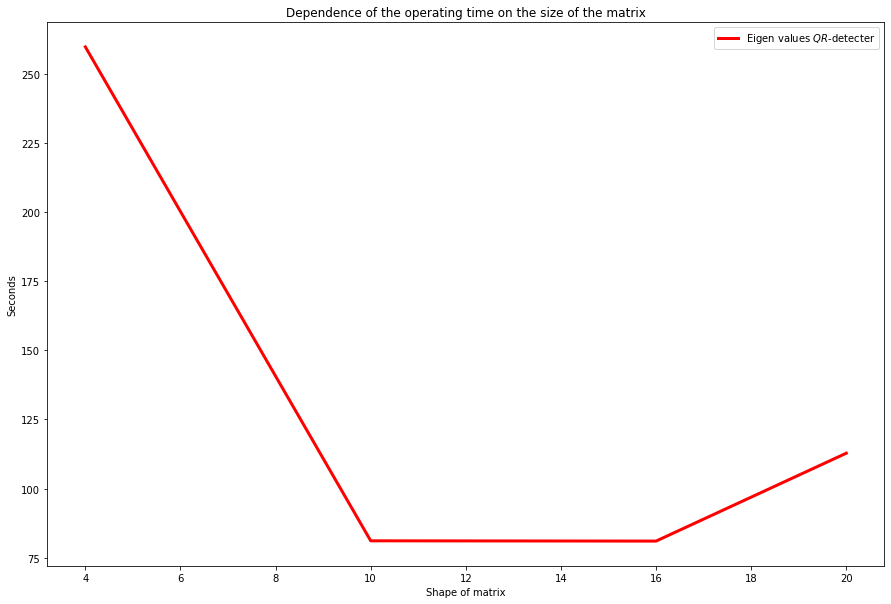

In [18]:
list_of_orders = [4, 10, 16, 20]
list_of_time_task_3 = []

def solving_time(order):
    matrix = generate_quadratic_matrix(order)
    result = %timeit -n1 -r1 -o -q -p0 Roots_detecter(QR_algorithm(np.matrix(Arnoldi_algorithm(Matrix(matrix[:order, :order]), order, False)[1], dtype=float), order * 10))
    list_of_time_task_3.append(result.compile_time)
    print(list_of_time_task_3[-1])
    
    
for o in list_of_orders:
    solving_time(o)
plt.figure(figsize=[15, 10])
plt.plot(list_of_orders, [t * (10 ** 6) for t in list_of_time_task_3], color='red', linewidth=3, label='Eigen values $QR$-detecter')
plt.ylabel('Seconds')
plt.xlabel('Shape of matrix')
plt.title('Dependence of the operating time on the size of the matrix')
plt.legend()
plt.show()